In [1]:
import subprocess
import os
from pathlib import Path
import tempfile

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
os.environ['HEALPIX'] = '/home/petroff/dev/Healpix_3.50'

In [3]:
POLSPICE = '/home/petroff/dev/PolSpice_v03-05-02/build/spice'

In [4]:
# Data locations
psm_dir = Path('/data/users/petroff/psm-sims/outputnops512_updateddust')
base_result_path = Path('/data/users/petroff/ann-component-separation2_2/logs/2020-03-18-04-00-10')
sim_path = Path('/data/users/petroff/psm-sims/outputnops512_updateddust_processed')
planck_map_path = Path('/data/planck')

In [5]:
# Beam window (arcmin)
beam_window = 13.1

In [6]:
# Load normalization
y_max = np.load(sim_path / 'normalization.npz')['y_max']

In [7]:
near_gal_mask = np.ones(hp.nside2npix(512), dtype=np.bool)
near_gal_mask[hp.query_strip(512, np.deg2rad(90.5), np.deg2rad(89.5))] = False
near_gal_mask = hp.reorder(near_gal_mask, r2n=True)

# Spectra bias

Compute spectra for first 100 examples from training set to look for and correct bias

In [8]:
ref_map_cls = []
for i in range(100):
    with tempfile.NamedTemporaryFile() as cl_file:
        subprocess.run([POLSPICE, '-mapfile', str(psm_dir / f'sim{i:04d}/cmb.fits'), '-beam', str(beam_window), '-pixelfile', 'YES', '-clfile', cl_file.name])
        ref_map_cls.append(np.loadtxt(cl_file.name, unpack=True)[1])
ref_map_cls = np.array(ref_map_cls)

In [9]:
train_sim_cl_sets = []

for j in range(100):
    train_sims_raw = np.load(base_result_path / f'train{j:04d}_raw.npz')['arr_0']
    results = train_sims_raw[:, :, 0] + np.random.normal(scale=np.sqrt(np.exp(-train_sims_raw[:, :, 1])))
    full_result = np.stack([np.mean(results, axis=0), -np.log(np.var(results, axis=0))], axis=1)
    full_result[..., 0] = (full_result[..., 0] - 0.5) * y_max * 2
    sim_mask = np.sqrt(np.exp(-full_result[:, 1])) * y_max * 2 <= 50  # Exclude pixels with predicted error above 50uK
    
    train_sim_cl_set = []
    
    with tempfile.NamedTemporaryFile() as weights_file:
        with tempfile.NamedTemporaryFile() as mask_file:
            hp.write_map(weights_file.name, hp.reorder(full_result[:, 1] - np.nanmin(full_result[:, 1]), n2r=True))
            hp.write_map(mask_file.name, hp.reorder(sim_mask, n2r=True))
            for i in range(train_sims_raw.shape[0]):
                with tempfile.NamedTemporaryFile() as map_file:
                    with tempfile.NamedTemporaryFile() as cl_file:
                        hp.write_map(map_file.name, hp.reorder((train_sims_raw[i, :, 0] + np.random.normal(scale=np.sqrt(np.exp(-train_sims_raw[i, :, 1]))) - 0.5) * y_max * 2, n2r=True) / 1e6)
                        subprocess.run([POLSPICE, '-mapfile', map_file.name, '-weightfile', weights_file.name, '-maskfile', mask_file.name, '-beam', str(beam_window), '-pixelfile', 'YES', '-clfile', cl_file.name])
                        _, tmp_cl = np.loadtxt(cl_file.name, unpack=True)
                        train_sim_cl_set.append(tmp_cl)

    train_sim_cl_sets.append(np.mean(np.array(train_sim_cl_set), axis=0))

train_sim_cl_sets = np.array(train_sim_cl_sets)

In [10]:
quadratic_fit = np.polyfit(np.arange(ref_map_cls.shape[1])[2:900], (np.mean(ref_map_cls, axis=0) / np.mean(train_sim_cl_sets * 1e12, axis=0))[2:900], 2)
np.savetxt('spectra-bias-quadratic-fit.txt', quadratic_fit)
print(quadratic_fit)

[-1.11711836e-07  8.41279184e-05  1.00748066e+00]


In [11]:
np.savez_compressed('spectra-bias.npz', ref_map_cls=ref_map_cls, train_sim_cl_sets=train_sim_cl_sets)

In [12]:
print(f'mean absolute ratio error before correction: {np.mean(np.abs((np.mean(ref_map_cls, axis=0) / np.mean(train_sim_cl_sets * 1e12, axis=0))[2:900] - 1)) * 100:.3f}%')
print(f'mean absolute ratio error after correction: {np.mean(np.abs((np.mean(ref_map_cls, axis=0) / np.mean(train_sim_cl_sets * 1e12 * np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])), axis=0))[2:900] - 1)) * 100:.3f}%')

mean absolute ratio error before correction: 1.600%
mean absolute ratio error after correction: 0.276%


Text(0, 0.5, 'Ref map $C_\\ell$ / NN $C_\\ell$')

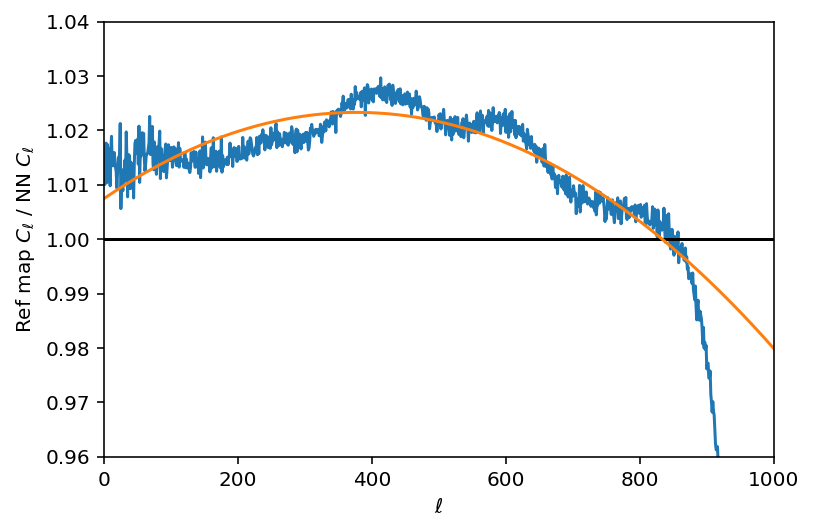

In [13]:
plt.plot((np.mean(ref_map_cls, axis=0) / np.mean(train_sim_cl_sets * 1e12, axis=0))[2:])
plt.ylim(0.96, 1.04)
plt.xlim(0, 1000)
plt.axhline(1, c='black')
plt.plot(np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])))
plt.xlabel("$\ell$")
plt.ylabel("Ref map $C_\ell$ / NN $C_\ell$")

Text(0, 0.5, 'Ref map $C_\\ell$ / NN $C_\\ell$')

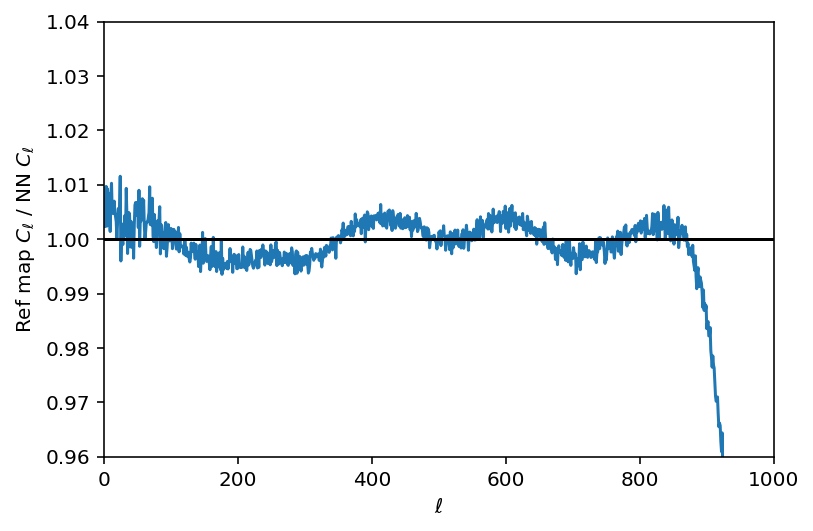

In [14]:
plt.plot((np.mean(ref_map_cls, axis=0) / np.mean(train_sim_cl_sets * 1e12 * np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])), axis=0))[2:])
plt.ylim(0.96, 1.04)
plt.xlim(0, 1000)
plt.axhline(1, c='black')
plt.xlabel("$\ell$")
plt.ylabel("Ref map $C_\ell$ / NN $C_\ell$")

In [15]:
ell = np.arange(1536)
np.mean(np.abs((np.mean(ref_map_cls, axis=0) - np.mean(train_sim_cl_sets * 1e12 * np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])), axis=0))[2:] * ell[2:] * (ell[2:] + 1) / (2 * np.pi))[2:900])

7.943359858795282

Text(0, 0.5, 'Theory $D_\\ell$ $-$ NN $D_\\ell$ ($\\mu K^2$)')

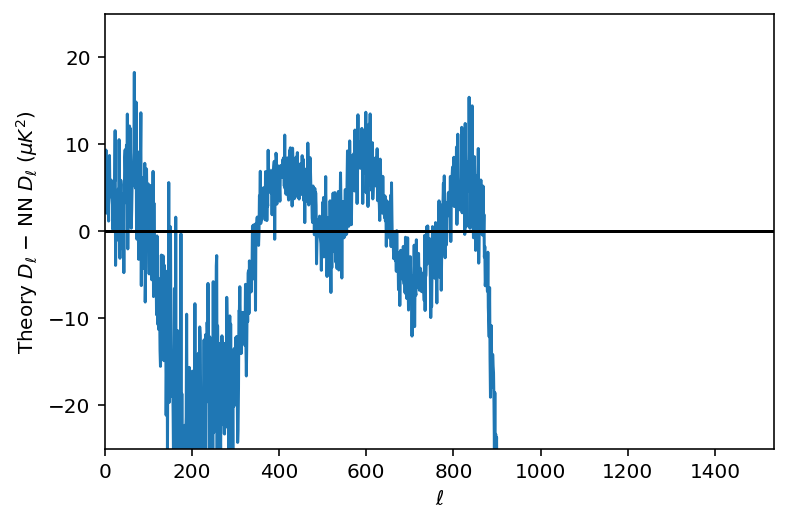

In [16]:
plt.plot((np.mean(ref_map_cls, axis=0) - np.mean(train_sim_cl_sets * 1e12 * np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])), axis=0))[2:] * ell[2:] * (ell[2:] + 1) / (2 * np.pi))
plt.ylim(-25, 25)
plt.xlim(0, 1536)
plt.axhline(0, c='black')
plt.xlabel("$\ell$")
plt.ylabel("Theory $D_\ell$ $-$ NN $D_\ell$ ($\mu K^2$)")

In [17]:
bin_size = 33
ell_binned = ell[2:1520].reshape(-1, bin_size).mean(axis=1)
dl_diff = (np.mean(ref_map_cls, axis=0) - np.mean(train_sim_cl_sets * 1e12 * np.poly1d(quadratic_fit)(np.arange(ref_map_cls.shape[1])), axis=0))[2:] * ell[2:] * (ell[2:] + 1) / (2 * np.pi)
binned_mean = dl_diff[2:1520].reshape(-1, bin_size).mean(axis=1)
binned_std = dl_diff[2:1520].reshape(-1, bin_size).std(axis=1) / np.sqrt(bin_size)

Text(0, 0.5, 'Theory $D_\\ell$ $-$ NN $D_\\ell$ ($\\mu K^2$)')

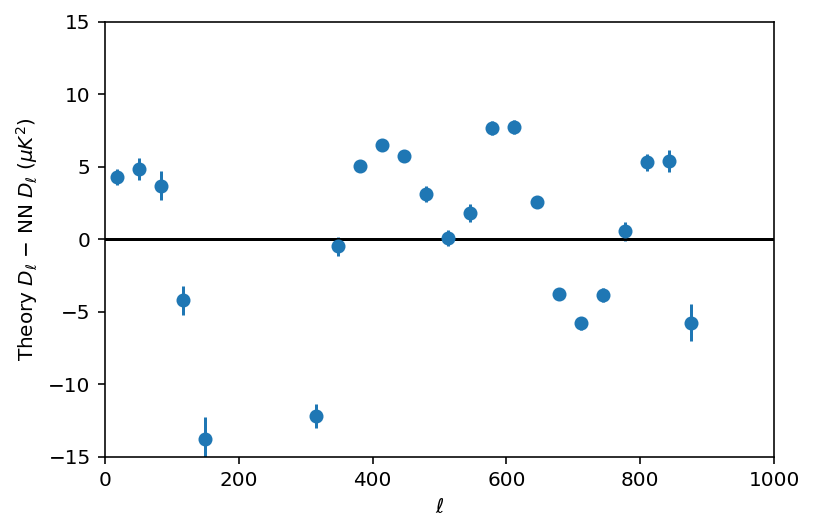

In [18]:
plt.errorbar(ell_binned, binned_mean, yerr=binned_std, ls='', marker='o')
plt.axhline(0, c='black')
plt.ylim(-15, 15)
plt.xlim(0, 1000)
plt.xlabel("$\ell$")
plt.ylabel("Theory $D_\ell$ $-$ NN $D_\ell$ ($\mu K^2$)")

## Simulation map from test set

In [19]:
y_raw = hp.reorder(hp.read_map(psm_dir / f'sim0999/cmb.fits', verbose=False), r2n=True) / 1e6  # Component map is in uK_CMB

In [20]:
# Reference map
with tempfile.NamedTemporaryFile() as map_file:
    with tempfile.NamedTemporaryFile() as cl_file:
        hp.write_map(map_file.name, hp.reorder(y_raw, n2r=True))
        subprocess.run([POLSPICE, '-mapfile', map_file.name, '-beam', str(beam_window), '-pixelfile', 'YES', '-clfile', cl_file.name])
        ell, ref_cl = np.loadtxt(cl_file.name, unpack=True)

In [21]:
np.savetxt('sim-ref-cl.txt', ref_cl)

In [22]:
# Load results
result_sim = np.load(base_result_path / 'test0999.npz')['arr_0']
sim_raw = np.load(base_result_path / 'test0999_raw.npz')['arr_0']

In [23]:
sim_mask = np.sqrt(np.exp(-result_sim[:, 1])) * y_max * 2 <= 50  # Exclude pixels with predicted error above 50uK

In [24]:
sim_cl_set = []

# Reconstructed map
with tempfile.NamedTemporaryFile() as weights_file:
    with tempfile.NamedTemporaryFile() as mask_file:
        hp.write_map(weights_file.name, hp.reorder(result_sim[:, 1] - np.nanmin(result_sim[:, 1]), n2r=True))
        hp.write_map(mask_file.name, hp.reorder(sim_mask, n2r=True))
        for i in range(sim_raw.shape[0]):
            with tempfile.NamedTemporaryFile() as map_file:
                with tempfile.NamedTemporaryFile() as cl_file:
                    hp.write_map(map_file.name, hp.reorder((sim_raw[i, :, 0] + np.random.normal(scale=np.sqrt(np.exp(-sim_raw[i, :, 1]))) - 0.5) * y_max * 2, n2r=True) / 1e6)
                    subprocess.run([POLSPICE, '-mapfile', map_file.name, '-weightfile', weights_file.name, '-maskfile', mask_file.name, '-beam', str(beam_window), '-pixelfile', 'YES', '-clfile', cl_file.name])
                    _, tmp_cl = np.loadtxt(cl_file.name, unpack=True)
                    sim_cl_set.append(tmp_cl)

sim_cl_set = np.array(sim_cl_set)

In [25]:
np.savetxt('sim-ann-cl.txt', np.mean(sim_cl_set, axis=0))

In [26]:
hp.write_map('sim-ann-map.fits', hp.reorder(result_sim[:, 0], n2r=True), coord='G', column_units='uK')
hp.write_map('sim-ann-map-err.fits', hp.reorder(np.sqrt(np.exp(-result_sim[:, 1])) * y_max * 2, n2r=True), coord='G', column_units='uK')

## Evaluation using Planck maps

In [27]:
# Load results
result_planck = np.load(base_result_path / 'planck.npz')['arr_0']

In [28]:
strip_mask = np.zeros(hp.nside2npix(512), dtype=np.bool)
strip_mask[hp.query_strip(512, np.deg2rad(100), np.deg2rad(80))] = True
strip_mask = hp.reorder(strip_mask, r2n=True)
result_median = np.nanmedian(result_planck[:, 0][strip_mask])

In [29]:
result_median

1.1501560095386414

In [30]:
planck_raw = np.load(base_result_path / 'planck_raw.npz')['arr_0']

In [31]:
planck_mask = np.sqrt(np.exp(-result_planck[:, 1])) * y_max * 2 <= 50  # Exclude pixels with predicted error above 50uK

In [32]:
planck_cl_set = []

# Reconstructed map
with tempfile.NamedTemporaryFile() as weights_file:
    with tempfile.NamedTemporaryFile() as mask_file:
        hp.write_map(weights_file.name, hp.reorder(result_planck[:, 1] - np.nanmin(result_planck[:, 1]), n2r=True))
        hp.write_map(mask_file.name, hp.reorder(planck_mask, n2r=True))
        for i in range(planck_raw.shape[0]):
            with tempfile.NamedTemporaryFile() as map_file:
                with tempfile.NamedTemporaryFile() as cl_file:
                    hp.write_map(map_file.name, hp.reorder((planck_raw[i, :, 0] + np.random.normal(scale=np.sqrt(np.exp(-planck_raw[i, :, 1]))) - 0.5) * y_max * 2 - result_median, n2r=True) / 1e6)
                    subprocess.run([POLSPICE, '-mapfile', map_file.name, '-weightfile', weights_file.name, '-maskfile', mask_file.name, '-beam', str(beam_window), '-pixelfile', 'YES', '-clfile', cl_file.name])
                    _, tmp_cl = np.loadtxt(cl_file.name, unpack=True)
                    planck_cl_set.append(tmp_cl)

planck_cl_set = np.array(planck_cl_set)

In [33]:
np.savetxt('planck-ann-cl.txt', np.mean(planck_cl_set, axis=0))
np.savetxt('planck-ann-cl-std.txt', np.std(planck_cl_set, axis=0))

In [34]:
hp.write_map('planck-ann-map.fits', hp.reorder(result_planck[:, 0], n2r=True), coord='G', column_units='uK')
hp.write_map('planck-ann-map-err.fits', hp.reorder(np.sqrt(np.exp(-result_planck[:, 1])) * y_max * 2, n2r=True), coord='G', column_units='uK')

# Statistics

## Simulation map from test set

In [35]:
print('mean predicted error:', f'{np.mean(np.sqrt(np.exp(-result_sim[:, 1][sim_mask])) * y_max * 2):.2f} uK')
print('mean difference:', f'{np.mean(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask])):.2f} uK')
print('weighted mean difference:', f'{np.average(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask]), weights=result_sim[:, 1][sim_mask] - np.min(result_sim[:, 1][sim_mask])):.2f} uK')
print('median predicted error:', f'{np.median(np.sqrt(np.exp(-result_sim[:, 1][sim_mask])) * y_max * 2):.2f} uK')
print('median difference:', f'{np.median(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask])):.2f} uK')
print(f'within 1-sigma: {np.mean(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask]) <= np.sqrt(np.exp(-result_sim[:, 1][sim_mask])) * y_max * 2) * 100:.1f}%')
print(f'within 2-sigma: {np.mean(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask]) <= np.sqrt(np.exp(-result_sim[:, 1][sim_mask])) * y_max * 2 * 2) * 100:.1f}%')
print(f'within 3-sigma: {np.mean(np.abs(y_raw[sim_mask] * 1e6 - result_sim[:, 0][sim_mask]) <= np.sqrt(np.exp(-result_sim[:, 1][sim_mask])) * y_max * 2 * 3) * 100:.1f}%')

mean predicted error: 5.36 uK
mean difference: 3.80 uK
weighted mean difference: 3.42 uK
median predicted error: 4.46 uK
median difference: 2.70 uK
within 1-sigma: 75.3%
within 2-sigma: 96.4%
within 3-sigma: 99.2%


In [36]:
print('mean difference (>10deg from Galactic plane):', f'{np.mean(np.abs(y_raw[strip_mask] * 1e6 - result_sim[:, 0][strip_mask])):.2f} uK')
print('mean difference (within <0.5deg from Galactic plane):', f'{np.mean(np.abs(y_raw[near_gal_mask] * 1e6 - result_sim[:, 0][near_gal_mask])):.2f} uK')
print('mean predicted error (>10deg from Galactic plane):', f'{np.mean(np.sqrt(np.exp(-result_sim[:, 1][strip_mask])) * y_max * 2):.2f} uK')
print('mean predicted error (within <0.5deg from Galactic plane):', f'{np.mean(np.sqrt(np.exp(-result_sim[:, 1][near_gal_mask])) * y_max * 2):.2f} uK')

mean difference (>10deg from Galactic plane): 3.58 uK
mean difference (within <0.5deg from Galactic plane): 37.91 uK
mean predicted error (>10deg from Galactic plane): 6.71 uK
mean predicted error (within <0.5deg from Galactic plane): 76.50 uK


## Evaluation using Planck maps

In [37]:
commander_map = hp.ud_grade(hp.smoothing(hp.read_map(planck_map_path / 'COM_CMB_IQU-commander_2048_R3.00_full.fits', field=0), np.deg2rad(beam_window / 60), use_pixel_weights=True), 512, order_out='NESTED')
nilc_map = hp.ud_grade(hp.smoothing(hp.read_map(planck_map_path / 'COM_CMB_IQU-nilc_2048_R3.00_full.fits', field=0), np.deg2rad(beam_window / 60), use_pixel_weights=True), 512, order_out='NESTED')
sevem_map = hp.ud_grade(hp.smoothing(hp.read_map(planck_map_path / 'COM_CMB_IQU-sevem_2048_R3.01_full.fits', field=0), np.deg2rad(beam_window / 60), use_pixel_weights=True), 512, order_out='NESTED')
smica_map = hp.ud_grade(hp.smoothing(hp.read_map(planck_map_path / 'COM_CMB_IQU-smica_2048_R3.00_full.fits', field=0), np.deg2rad(beam_window / 60), use_pixel_weights=True), 512, order_out='NESTED')

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/etc/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Sigma is 5.563058 arcmin (0.001618 rad) 
-> fwhm is 13.100000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Sigma is 5.563058 arcmin (0.001618 rad) 
-> fwhm is 13.100000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Sigma is 5.563058 arcmin (0.001618 rad) 
-> fwhm is 13.100000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Sigma is 5.563058 arcmin (0.001618 rad) 
-> fwhm is 13.100000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [38]:
print('mean predicted error:', f'{np.mean(np.sqrt(np.exp(-result_planck[:, 1][planck_mask])) * y_max * 2):.2f} uK')
print('mean difference:', f'{np.mean(np.abs(result_planck[:, 0][planck_mask] - result_median - commander_map[planck_mask] * 1e6)):.2f} uK')
print('weighted mean difference:', f'{np.average(np.abs(result_planck[:, 0][planck_mask] - result_median - commander_map[planck_mask] * 1e6), weights=result_planck[:, 1][planck_mask] - np.min(result_planck[:, 1][planck_mask])):.2f} uK')
print('median predicted error:', f'{np.median(np.sqrt(np.exp(-result_planck[:, 1][planck_mask])) * y_max * 2):.2f} uK')
print('median difference:', f'{np.median(np.abs(result_planck[:, 0] - result_median - commander_map * 1e6)[planck_mask]):.2f} uK')
print(f'within 1-sigma: {np.mean(np.abs(result_planck[:, 0] - result_median - commander_map * 1e6)[planck_mask] <= (np.sqrt(np.exp(-result_planck[:, 1][planck_mask])) * y_max * 2)) * 100:.1f}%')
print(f'within 2-sigma: {np.mean(np.abs(result_planck[:, 0] - result_median - commander_map * 1e6)[planck_mask] <= (np.sqrt(np.exp(-result_planck[:, 1][planck_mask])) * y_max * 2 * 2)) * 100:.1f}%')
print(f'within 3-sigma: {np.mean(np.abs(result_planck[:, 0] - result_median - commander_map * 1e6)[planck_mask] <= (np.sqrt(np.exp(-result_planck[:, 1][planck_mask])) * y_max * 2 * 3)) * 100:.1f}%')

mean predicted error: 5.47 uK
mean difference: 6.23 uK
weighted mean difference: 4.72 uK
median predicted error: 4.51 uK
median difference: 2.54 uK
within 1-sigma: 74.9%
within 2-sigma: 90.7%
within 3-sigma: 95.3%


In [39]:
print('nilc mean difference:', f'{np.mean(np.abs(nilc_map[planck_mask] - commander_map[planck_mask])) * 1e6:.2f} uK')
print('sevem mean difference:', f'{np.mean(np.abs(sevem_map[planck_mask] - commander_map[planck_mask])) * 1e6:.2f} uK')
print('smica mean difference:', f'{np.mean(np.abs(smica_map[planck_mask] - commander_map[planck_mask])) * 1e6:.2f} uK')
print('nilc weighted mean difference:', f'{np.average(np.abs(nilc_map[planck_mask] - commander_map[planck_mask]), weights=result_planck[:, 1][planck_mask] - np.min(result_planck[:, 1][planck_mask])) * 1e6:.2f} uK')
print('sevem weighted mean difference:', f'{np.average(np.abs(sevem_map[planck_mask] - commander_map[planck_mask]), weights=result_planck[:, 1][planck_mask] - np.min(result_planck[:, 1][planck_mask])) * 1e6:.2f} uK')
print('smica weighted mean difference:', f'{np.average(np.abs(smica_map[planck_mask] - commander_map[planck_mask]), weights=result_planck[:, 1][planck_mask] - np.min(result_planck[:, 1][planck_mask])) * 1e6:.2f} uK')

nilc mean difference: 5.83 uK
sevem mean difference: 7.09 uK
smica mean difference: 4.52 uK
nilc weighted mean difference: 4.90 uK
sevem weighted mean difference: 5.97 uK
smica weighted mean difference: 3.58 uK
